In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [2]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

subjects_bak_spec = read_dataset("../../../../../data/datasets/filtered/subjects_bak_spec_filtered_lof.csv")
subjects_magistr = read_dataset("../../../../../data/datasets/filtered/subjects_magistr_filtered_lof.csv")

In [3]:
X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

Лучший порог: 0.010, F1 для класса 1: 0.370
{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 32, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(max_depth=32))])

Отчёт классификации с оптимальным порогом:

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        99
           1       0.40      0.34      0.37        29

    accuracy                           0.73       128
   macro avg       0.61      0.60      0.60       128
weighted avg       0.72      0.73      0.73       128



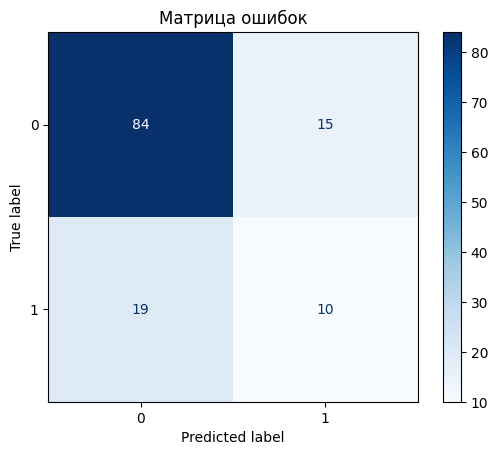

                                            feature  importance
37                      Позиция студента в рейтинге    0.396335
7                  Полных лет на момент поступления    0.160223
1                            Cумма баллов испытаний    0.107570
9                           Общее количество долгов    0.105799
4                             Нуждается в общежитии    0.042015
2                           Балл за инд. достижения    0.037126
0                                         Приоритет    0.034197
12                          Human Development Index    0.033381
11                             fromSverdlovskRegion    0.027777
8                         Общее количество пересдач    0.015111
30                            Код направления 1: 10    0.013060
36                             Код направления 3: 4    0.011609
31                            Код направления 1: 11    0.008204
10                                 fromEkaterinburg    0.006772
18                                      

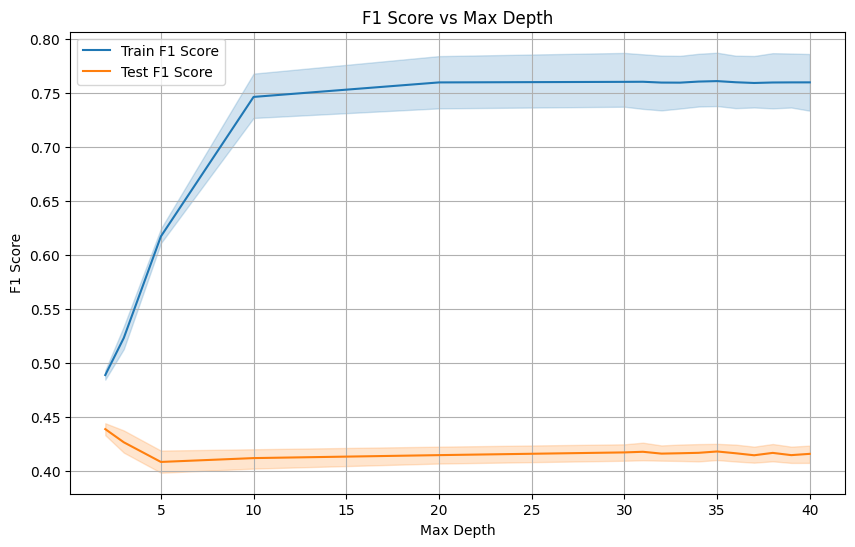

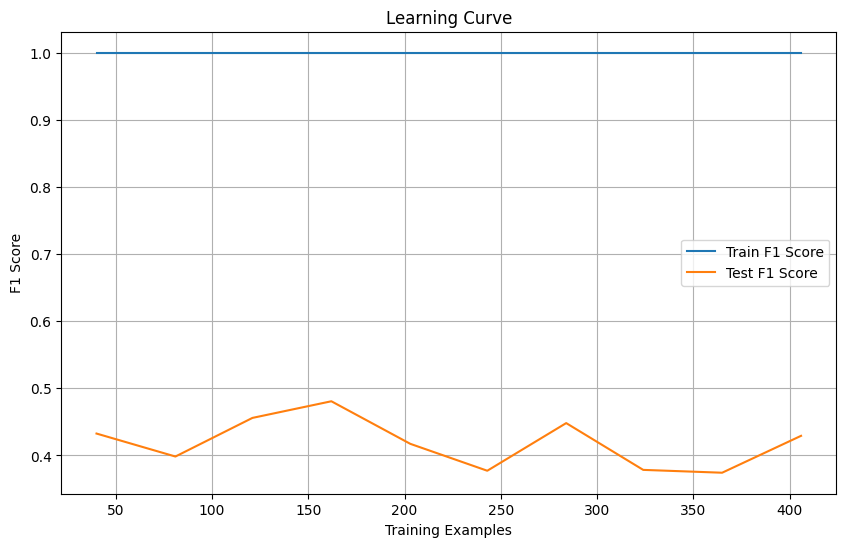

In [4]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.metrics import make_scorer, f1_score

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])
param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]
custom_scorer = make_scorer(f1_score, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/dec_tree_model_s_magistr_lof.joblib')

'''-----------------------------------------------------------------------------------------------------
                        ПОЛУЧЕНИЕ ЛУЧШЕГО ПОРОГА И СОЗДАНИЕ ОТЧЁТА С УЧЁТОМ ЭТОГО ПОРОГА
-----------------------------------------------------------------------------------------------------'''

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Лучший порог: {best_threshold:.3f}, F1 для класса 1: {best_f1:.3f}")

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]
y_pred_s_magistr = (y_probs >= best_threshold).astype(int)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации с оптимальным порогом:\n")
print(classification_report(y_test_s_magistr, y_pred_s_magistr))

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_magistr, y_pred_s_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('dec_tree/s_magistr/confusion_matrix_dec_tree.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

importances = best_model.named_steps['clf'].feature_importances_
feature_importances = pd.DataFrame({
    'feature': X_train_s_magistr.columns,
    'importance': importances
}).sort_values('importance', ascending=False)
print(feature_importances)

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('dec_tree/s_magistr/f1_vs_max_depth_dec_tree.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('dec_tree/s_magistr/learning_curve_dec_tree.png')
plt.show()

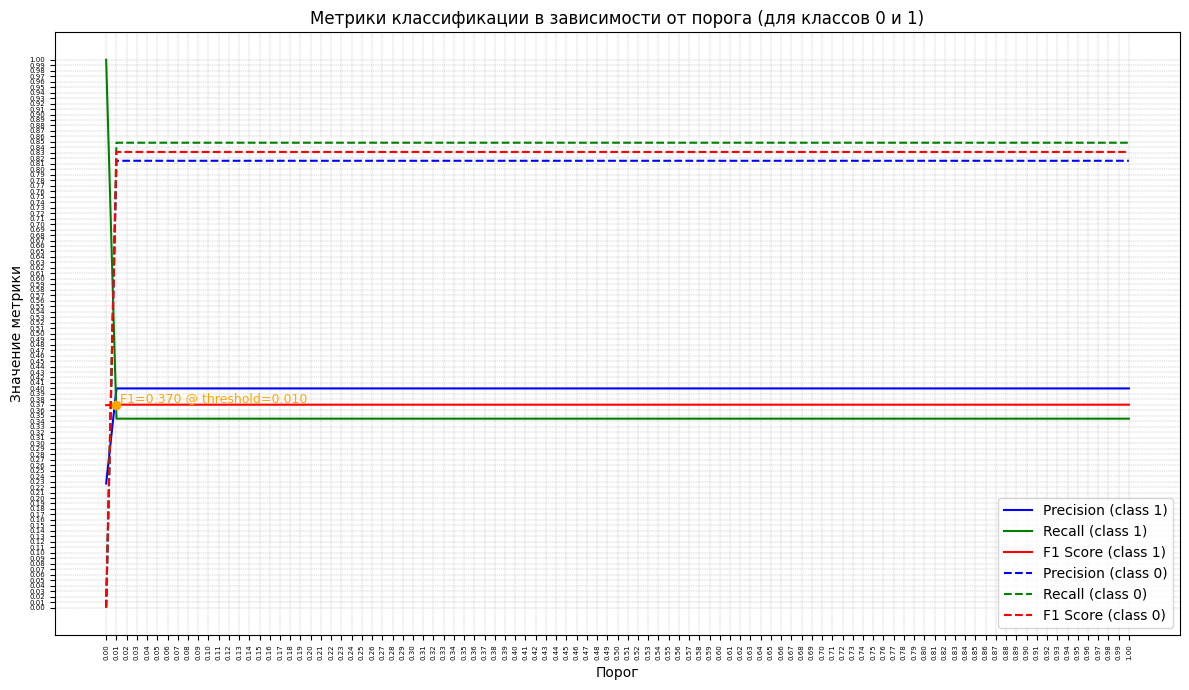

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

max_f1_idx = np.argmax(f1_scores_1)
max_f1_value = f1_scores_1[max_f1_idx]
max_threshold = thresholds[max_f1_idx]

save_path = 'dec_tree/s_magistr'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.scatter(max_threshold, max_f1_value, color='orange', zorder=5)
plt.text(max_threshold, max_f1_value,
         f' F1={max_f1_value:.3f} @ threshold={max_threshold:.3f}',
         fontsize=9, color='orange', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_dec_tree.png'), dpi=300)
plt.show()

Лучший порог: 0.525, F1 для класса 1: 0.713
{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 15}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=2,
                                        min_samples_split=15))])

Отчёт классификации с оптимальным порогом:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       246
           1       0.75      0.68      0.71        60

    accuracy                           0.89       306
   macro avg       0.83      0.81      0.82       306
weighted avg       0.89      0.89      0.89       306



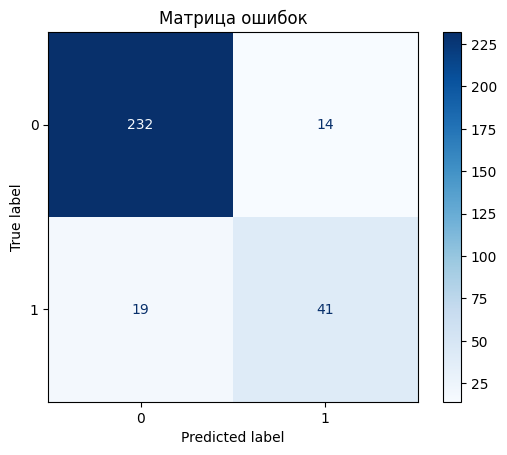

                                            feature  importance
10                          Общее количество долгов    0.761018
39                      Позиция студента в рейтинге    0.167833
1                            Cумма баллов испытаний    0.023162
37                             Код направления 3: 3    0.014322
11                                 fromEkaterinburg    0.008874
12                             fromSverdlovskRegion    0.008769
24                                 Профильная Школа    0.008535
21                                       Специалист    0.007488
7                                               Пол    0.000000
6                      Иностранный абитуриент (МОН)    0.000000
5                             Нуждается в общежитии    0.000000
4                                          Контракт    0.000000
3                           Балл за инд. достижения    0.000000
2                                               БВИ    0.000000
0                                       

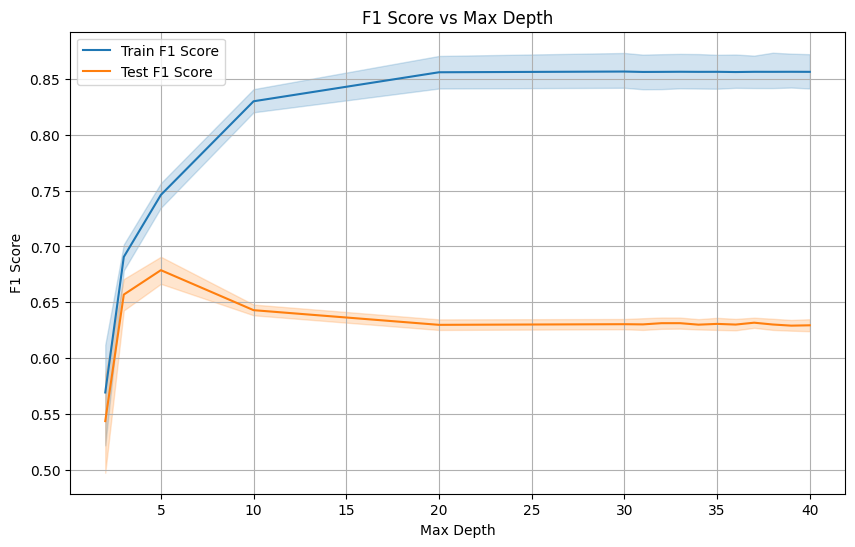

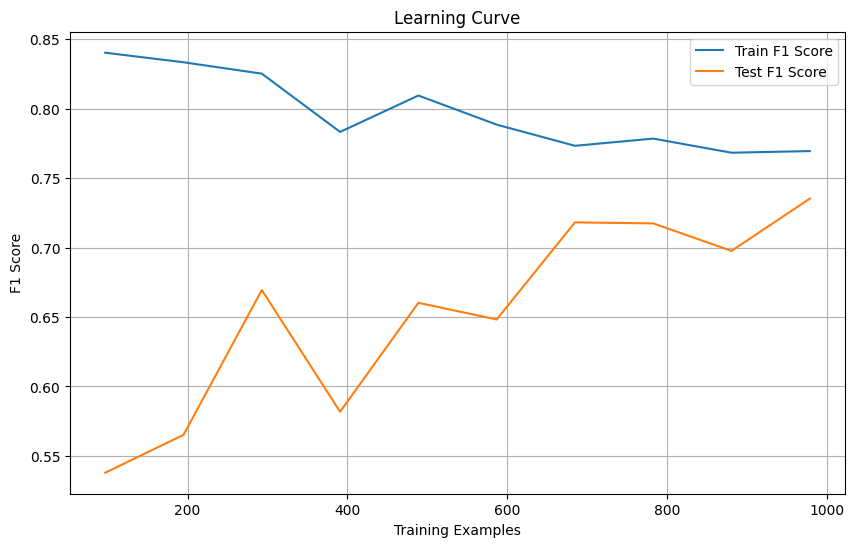

In [6]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.metrics import make_scorer, f1_score

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=random_state))
])
param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]
custom_scorer = make_scorer(f1_score, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/dec_tree_model_s_bak_spec_lof.joblib')

'''-----------------------------------------------------------------------------------------------------
                        ПОЛУЧЕНИЕ ЛУЧШЕГО ПОРОГА И СОЗДАНИЕ ОТЧЁТА С УЧЁТОМ ЭТОГО ПОРОГА
-----------------------------------------------------------------------------------------------------'''

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Лучший порог: {best_threshold:.3f}, F1 для класса 1: {best_f1:.3f}")

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]
y_pred_s_bak_spec = (y_probs >= best_threshold).astype(int)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации с оптимальным порогом:\n")
print(classification_report(y_test_s_bak_spec, y_pred_s_bak_spec))

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_bak_spec, y_pred_s_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('dec_tree/s_bak_spec/confusion_matrix_dec_tree.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

importances = best_model.named_steps['clf'].feature_importances_
feature_importances = pd.DataFrame({
    'feature': X_train_s_bak_spec.columns,
    'importance': importances
}).sort_values('importance', ascending=False)
print(feature_importances)

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('dec_tree/s_bak_spec/f1_vs_max_depth_dec_tree.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('dec_tree/s_bak_spec/learning_curve_dec_tree.png')
plt.show()

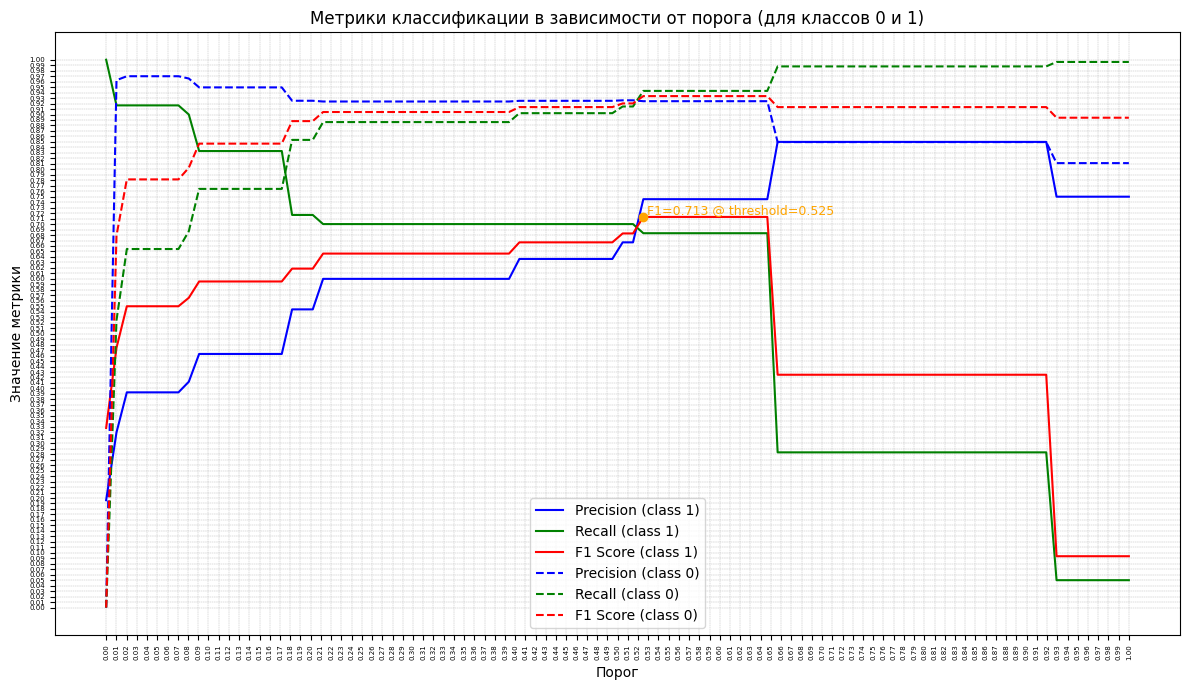

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

max_f1_idx = np.argmax(f1_scores_1)
max_f1_value = f1_scores_1[max_f1_idx]
max_threshold = thresholds[max_f1_idx]

save_path = 'dec_tree/s_bak_spec'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.scatter(max_threshold, max_f1_value, color='orange', zorder=5)
plt.text(max_threshold, max_f1_value,
         f' F1={max_f1_value:.3f} @ threshold={max_threshold:.3f}',
         fontsize=9, color='orange', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_dec_tree.png'), dpi=300)
plt.show()